# 5.11: Discussion - Face Detection Based on HoG Features and Binary Classifier

## Required Libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature
from sklearn.svm import SVC

## Step 1: Download all the datasets and testing images

Loaded 13233 positive and 30000 negative patches.
Positive patches reshaped: (13233, 62, 47)
Negative patches reshaped: (30000, 62, 47)


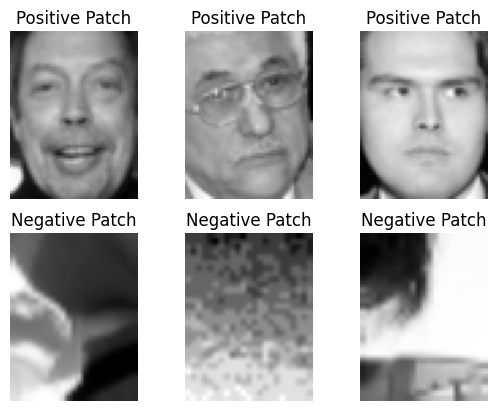

In [ ]:
# Load positive and negative image patches from the previous exercise. 
# The patches have the size 62x47 pixels.
# The format of the data is numpy arrays of shape (N, P), where P is the flattened size of each patch (62*47=2914) 
# and N is the number of patches
pos_images = np.load('data/positive_patches.npy')
neg_images = np.load('data/negative_patches.npy')
print(f'Loaded {pos_images.shape[0]} positive and {neg_images.shape[0]} negative patches.')
# Reshape the patches to their original dimensions
# I am trying a different syntax that doesn't loop through each image
# but instead reshapes the entire array at once in memory, so it doesn't need to copy each image individually
# This should be faster and more memory efficient than the list comprehension.
# -1 means the number of images is calculated automatically based on the total size
# cf. https://numpy.org/doc/stable/reference/generated/numpy.reshape.html
pos_images_reshaped = pos_images.reshape((-1, 62, 47))
neg_images_reshaped = neg_images.reshape((-1, 62, 47))
# Print the shapes to verify
print(f'Positive patches reshaped: {pos_images_reshaped.shape}')
print(f'Negative patches reshaped: {neg_images_reshaped.shape}')
# Verify the reshaping by displaying a few patches
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(pos_images_reshaped[i], cmap='gray')
    plt.title('Positive Patch')
    plt.axis('off')
    
    plt.subplot(2, 3, i+4)
    plt.imshow(neg_images_reshaped[i], cmap='gray')
    plt.title('Negative Patch')
    plt.axis('off')
plt.show()